# Use quantum operations to achieve computing objectives


The purpose of this notebook article is to demonstrate using quantum operations to achieve computing objectives. The term *quantum operation* refers to a higher level method that may be implemented with one or many low-level quantum gates.  More generally, the goal is to demonstrate the notion that quantum algorithms use quantum operations to implement constraints that coerce qubits from representing any possible outcomes to representing the outcomes that satisfy the constraints.

Using John Preskill's terminology, we now have "noisy intermediate scale quantum" (NISQ) computers that can obtain a desired outcome with high probablility, i.e. where the desired outcome rises well above the noise that can occur within the current early-stage quantum computing devices. In this notebook article, we will implement a classical computing algorithm in order to see how differently it is done in quantum computing, and we will see that the desired outcome occurs by far the most frequently.  However, note that the emphasis is on understanding how the quantum operations achieve an easily understood result, and so there is no quantum computing speedup in this case.

In this notebook article, we will create a **quantum circuit** that uses quantum operations to perform **addition** of two single bit numbers. This problem reduces to developing quantum operation sequences that perform a classical 'XOR' operation to calculate the least significant bit and a classical 'AND' operation to calculate the most significant bit of the answer. This can be seen in the two columns of the expected answers below:

$0+0=00$<br/>
$0+1=01$<br/>
$1+0=01$<br/>
$1+1=10$<br/>

### Table of contents

1. [Install and import Qiskit](#install)
2. [The memory model for this quantum circuit](#memory)
3. [Initialize and input the quantum circuit](#initial)
4. [Performing 'XOR' with Quantum Operations](#xor)
5. [Performing 'AND' with Quantum Operations](#and)
6. [Simulate the quantum circuit](#simulate)
7. [Run the experiment on a real IBM Q quantum computer](#run)
8. [Conclusion](#conclusion)

## 1. Install and import Qiskit<a id="install"></a>

The Quantum Information Science development kit, or Qiskit, is a library and framework for either connecting to and running quantum computing programs on a real IBM Q quantum computer or simulating them on the user's classical computing environment. The first cell below contains code to run once to get Qiskit installed. The second cell below should be run any time the notebook starts to import the parts of Qiskit relevant to this notebook's operations.

In [1]:
# !pip install --user qiskit

In [2]:
# Import the Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError
from qiskit import execute, IBMQ, Aer
from qiskit.backends.ibmq import least_busy

## 2. The memory model for this quantum circuit<a id="memory"></a>

This notebook uses qubits $q_0$ and $q_1$ for the inputs. 

Qubit $q_2$ will be used for the least significant bit of the answer, and qubit $q_3$ will be for the most significant bit.

In [3]:
num_qubits = 4

# Create a Quantum Register with the desired number of qubits.
q = QuantumRegister(num_qubits)
# Create a Classical Register with the same number of classical computing bits.
c = ClassicalRegister(num_qubits)

## 3. Initialize and input the quantum circuit <a id="initial"></a>

The following cell creates the quantum circuit with the quantum and classical registers. Then, it assigns the input to qubits $q_0$ and $q_1$.

The ground state |$0\rangle$ is the default, so an X gate is used on qubits that must start in the excited state |$1\rangle$.
The X gate performs a $\pi$ radian rotation about the $X$-axis, which rotates |$0\rangle$ (a.k.a. |+$z\rangle$) through the $Y$-axis to |$1\rangle$ (a.k.a. |-$z\rangle$). The X gate is sometimes called a NOT gate, but note that it performs a $\pi$ radian rotation that happens to perform a classical NOT, or bit flip, only when the qubit is in |$0\rangle$ or |$1\rangle$ state. **To change the input**, comment out the X gate operation on any qubits that should be |$0\rangle$ and ensure the X gate is not commented on any qubits that should be initialized to |$1\rangle$. 

In [4]:
# Create the initial quantum circuit with the quantum and classical registers
qc = QuantumCircuit(q, c)

# INPUT: Default qubit values are ground state |0>. Uncomment to flip either or both to excited state |1> 
qc.x(q[0])
qc.x(q[1])

## 4. Performing 'XOR' with quantum operations<a id="xor"></a>

An 'XOR' can be performed with two quantum operations. The inputs of the 'XOR' come from qubits $q_0$ and $q_1$, and the output of the 'XOR' will go to qubit $q_2$. The output qubit, $q_2$, starts in the ground state, |$0\rangle$. 

We first apply a controlled-not operation with $q_2$ as the target of the control and with $q_0$ as the source. The controlled-not is also called CNOT, or CX. This operation negates the target if the source is excited (|$1\rangle$). By itself, this operation changes $q_2$ from |$0\rangle$ to |$1\rangle$ if $q_0$ is |$1\rangle$, and it leaves $q_2$ unchanged if $q_0$ is |$0\rangle$.

Next, we apply a CNOT with qubit $q_2$ as the target and with $q_1$ as the source. If $q_1$ is |$0\rangle$, then $q_2$ is unchanged from the effect of the CNOT with $q_0$. Therefore, we have:

$q_0$=|$0\rangle$ $q_1$=|$0\rangle$ results in $q_2$=|$0\rangle$

$q_0$=|$1\rangle$ $q_1$=|$0\rangle$ results in $q_2$=|$1\rangle$

However, if $q_1$ is |$1\rangle$, then $q_2$ is inverted relative to the effect of the CNOT with $q_0$. Therefore, we have: 

$q_0$=|$0\rangle$ $q_1$=|$1\rangle$ results in $q_2$=|$1\rangle$

$q_0$=|$1\rangle$ $q_1$=|$1\rangle$ results in $q_2$=|$0\rangle$

This concludes the method for performing 'XOR' with quantum operation, which calculates the least significant bit of the single bit addition result.

In [5]:
# CNOT (controlled-not): source qubit 0 flips target qubit 2 if the source qubit 0 is 1
qc.cx(q[0], q[2])
# CNOT (controlled-not): source qubit 1 flips target qubit 2 if the source qubit 1 is 1
qc.cx(q[1], q[2])

## 5. Performing 'AND' with quantum operations<a id="and"></a>

An 'AND' can be performed with three quantum operations. The inputs of the 'AND' come from qubits $q_0$ and $q_1$, and the output of the 'AND' will go to qubit $q_3$. The output qubit, $q_3$, starts in the ground state, |$0\rangle$. 

**Operation 1.** We target qubit $q_3$ with a controlled-Hadamard operation that is controlled by the source qubit $q_0$. This changes the target $q_3$ from  |$0\rangle$ to |+$x\rangle$ if the source $q_0$ is |$1\rangle$. The operation looks like this on the Bloch sphere:

<img src="https://github.com/IBMDataScience/sample-notebooks/raw/master/Files/ANDonBlochSphereI.png" alt="Controlled Hadamard on Qubit 3 if Qubit 0 is 1" style="width: 30%;height: 30%"/>

**Operation 2.** Next, we target qubit $q_3$ with a controlled-Z operation that is controlled by the source qubit $q_1$. This changes the phase of the target $q_3$ by rotating $\pi$ radians around $Z$-axis if the source qubit $q_1$ is |$1\rangle$. The operation looks like this on the Bloch sphere:

<img src="https://github.com/IBMDataScience/sample-notebooks/raw/master/Files/ANDonBlochSphereII.png" alt="Controlled Z Phase Change on Qubit 3 if Qubit 1 is 1" style="width: 40%;height: 40%"/>

The following are the results so far:
* For input $q_1$ $q_0$ = |$0\rangle$ |$0\rangle$, $q_3$ is not changed from |$0\rangle$
* For input $q_1$ $q_0$ = |$0\rangle$ |$1\rangle$, $q_3$ only changed to |+$x\rangle$
* For input $q_1$ $q_0$ = |$1\rangle$ |$0\rangle$, $q_3$ is at |$0\rangle$ because $q_0$ did not rotate it, and $q_1$ requests a $Z$-axis phase rotation, but |$0\rangle$ is along the $Z$-axis, so rotating it does nothing.
* For input $q_1$ $q_0$ = |$1\rangle$ |$1\rangle$, $q_3$ is |-$x\rangle$ due to $\pi$ phase rotation from |+$x\rangle$

**Operation 3.** Finally, we target $q_3$ with a controlled-Hadamard operation that is controlled by the source qubit $q_0$. Note above that when input $q_0$ is |$0\rangle$, $q_3$ is already in the correct state of |$0\rangle$. Therefore, we only take a further action if $q_0$ is |$1\rangle$.

When $q_0$ is |$1\rangle$, then the controlled-Hadamard operation maps the $X$-axis to the $Z$-axis, so |+$x\rangle$ is converted to |+$z\rangle$=|$0\rangle$ and |-$x\rangle$ is converted to |-$z\rangle$=|$1\rangle$. The operation looks like this on the Bloch sphere:

<img src="https://github.com/IBMDataScience/sample-notebooks/raw/master/Files/ANDonBlochSphereIII.png" alt="A Second Controlled Hadamard if Qubit 0 is 1" style="width: 40%;height: 40%"/>

This concludes the method for performing 'AND' with quantum operation, which calculates the most significant bit of the single bit addition result.

In [6]:
# 1. We target q3 with a controlled-Hadamard operation, controlled by source q0, which changes q3 from |0> to |+x> if q0 is 1.
qc.ch(q[0], q[3])
# 2. We target q3 with a controlled-Z operation, controlled by q1, which changes q3's phase (rotating by pi around the Z-axis) if q1 is 1.
qc.cz(q[1], q[3])
# 3. We target q3 with a controlled-Hadamard, controlled by source q0. If q0 is |1>, then q3 changes to |1> if q1 was also |1> and |0> otherwise 
qc.ch(q[0], q[3])

## 6. Perform the measurement<a id="perform"></a>
We use the code below to measure the state of the qubits, giving a classical computing answer.

In [7]:
# Collapse superpositions into an answer
qc.measure(q, c)

## 7. Simulate the quantum circuit<a id="simulate"></a>
On a simulator, we execute the quantum circuit that defines the input, performs the processing, and measures the output. Then, we render the output in the notebook user interface.

In [8]:
# Execute the quantum circuit that defines the input, performs the proessing, and measures the output
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator)

# Render the output in the notebook user interface
result = job.result()
print("Data Result:", result.get_data(qc))

Data Result: {'counts': {'1011': 1024}, 'snapshots': {}}


Based on the initialization in cell 5 above, the simulator always produces the result '10' (2) in qubits $q_3$ and $q_2$.

## 8. Run the experiment on a real IBM Q quantum computer<a id="run"></a>
Now we will set up to run on a real IBM Q quantum computer. The first cell below contains code that only has to run once per Python run-time to get it to work with your IBM Q Experience account. The second cell should be run once per notebook session to load the user's IBM Q quantum computer access token.

In [9]:
# This only has to be run once per Python run-time to get it to work with your IBM Q Experience account
# In the IBM Q Composer, click your avatar (top right), select My Account, click Advanced.
# If the API Token field is empty, click Regenerate. 
# Press Copy API Token in the composer, and then paste the result into the token string literal value below
# Uncomment the lines to run them, which only has to be done once.

#token = ''
#IBMQ.save_account(token)

In [10]:
# This loads the user's API access key, which was previously saved in a one-time setup above.
IBMQ.load_accounts()

Obtain a real IBM Q quantum computer that is available to run the job, then compile and execute on it. The commented code let's you obtain the least busy IBM Q quantum computer, or a specific other device. The uncommented line requests a particular 5 qubit IBM Q device.

In [11]:
result_counts = {}

try:
    # Obtain an available quantum computer
    ibmq_backends = IBMQ.backends()
    #device = least_busy(IBMQ.backends(simulator=False))
    device = IBMQ.get_backend('ibmqx4')
    #device = IBMQ.get_backend('ibmq_16_melbourne')
    print("Running on device: ", device)

    # Compile and execute the Quantum circuit on the quantum computer
    job_exp = execute(qc, device, shots=1024, max_credits=10)
    result_exp = job_exp.result()

    # Render the output in the notebook user interface
    print("experiment: ", result_exp)
    result_counts = result_exp.get_counts(qc)
except:
    print("All devices are currently unavailable.")

Running on device:  ibmqx4
experiment:  COMPLETED


In the results, the qubits are in the order $q_3$, $q_2$, $q_1$, and $q_0$, so we tally the outcomes based on the first two qubits as they are the output qubits. 

There are four possible outcomes for the two output qubits: 00, 01, 10, and 11. The expected outcome is 10. With 1024 shots, the noise outcome would be on the order of 256 shots per possible outcome. 

In the frequencies list and bar chart below, one can see that, by far, the **correct final state of the output qubits occurs more frequently than all other possible outcomes combined**. A most frequently occurring quantum computing outcome is precisely what a quantum experimentalist would investigate first within their real world application.

In [12]:
result_frequencies = {'00':0, '01':0, '10':0, '11':0 }
    
for key in result_counts.keys():
    freq_key = key[0:2]
    result_frequencies[freq_key] = result_frequencies[freq_key] + result_counts[key]
        
print(result_frequencies) 

{'00': 263, '10': 590, '01': 91, '11': 80}


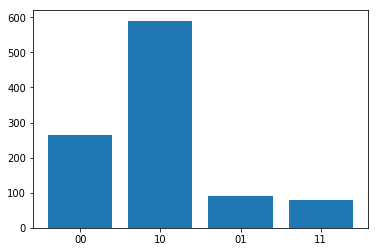

In [14]:
import matplotlib.pyplot as plt

D = result_frequencies

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

## 9. Conclusion<a id="conclusion"></a>

In this notebook, we have demonstrated how quantum algorithms use quantum operations to coerce qubits into representing the outcome or outcomes that satisfy the constraints of a problem. In the case of quantum addition of two qubits initialized with classical bit values, one output qubit had to satisfy the constraint of being excited if and only if the two input qubits differed, and a second output qubit had to satisfy the constraint of being excited if and only if both input qubits were excited. Not only did we simulate this quantum circuit, we ran it on a real IBM Q quantum computer. When we did, we witnessed the fact that in the NISQ era, one plus one is most probably two!

Finally, note that the quantum logical AND method we built above is also signicant because one can append an X gate, which performs a logical NOT, resulting in a NAND operation. In classical cmputing, the NAND operation is a universal gate that can be used to build all other classical computing circuits. **Therefore, any classical computing solution can be expressed... and we have only used 4 points of the Bloch sphere representing the total expressive power available to each qubit of a quantum computer.**

### Citations

1. <a href="https://qiskit.org/">Qiskit</a>. An open-source quantum computing framework for leveraging today's quantum processors in research, education, and business.

### Acknowledgements

The author gratefully acknowledges the thorough reviews and feedback by Luuk Ament and Robert Loredo.

### Author
**John M. Boyer, Ph.D.**<br/>
Distinguished Engineer and Master Inventor <br/>
IBM Global Chief Data Office

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>